In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('..', 'config'), 'donors_db_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()


import RecallAdjuster as ra
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


In [2]:
## FOR DONORS
### Train End Time is all end dates
base = datetime.datetime.strptime('2013-03-01', '%Y-%m-%d')   #Corresponding to latest train_end_time
date_pairs = []

# we can make x range to 20 months ago
for x in range(5, -1, -1):
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x)).strftime('%Y-%m-%d')
        )
    )

for i in range(0, len(date_pairs), 2):
    print(date_pairs[i], date_pairs[i+1])

('2010-03-01', '2010-03-01') ('2010-03-01', '2010-09-01')
('2010-09-01', '2010-09-01') ('2010-09-01', '2011-03-01')
('2011-03-01', '2011-03-01') ('2011-03-01', '2011-09-01')
('2011-09-01', '2011-09-01') ('2011-09-01', '2012-03-01')
('2012-03-01', '2012-03-01') ('2012-03-01', '2012-09-01')
('2012-09-01', '2012-09-01') ('2012-09-01', '2013-03-01')


### understanding the sensitive variable class size

29533 104080


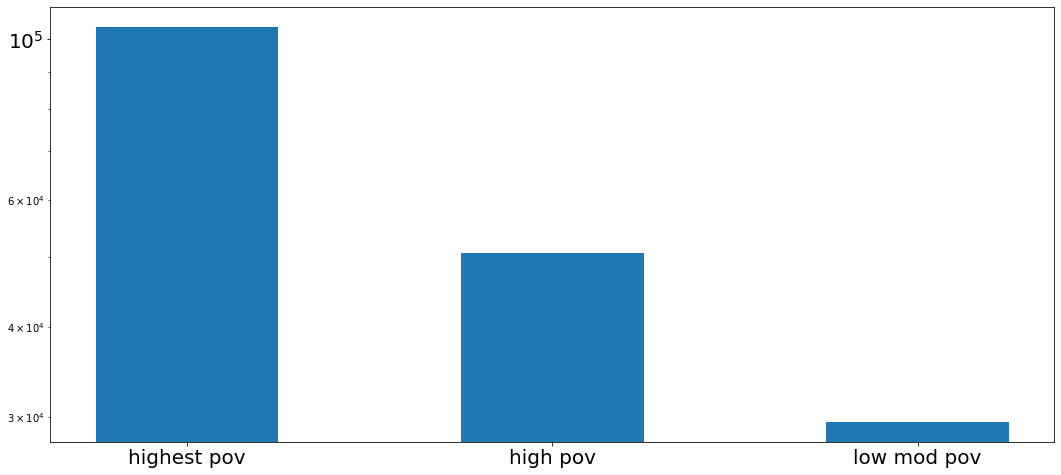

In [9]:
query = """
select poverty_level, count(*) as c from hemank_bias_class_test.entity_demos
group by poverty_level
"""
df = pd.read_sql(query, conn)
poverty_levels = df['poverty_level'].values
counts = df['c'].values

plt.figure(figsize=(18,8))
plt.bar(range(len(poverty_levels)), counts, width=0.5)
plt.xticks(range(len(poverty_levels)), [str(pl).replace("_", " ") for pl in poverty_levels], fontsize=20)
plt.yscale('log')
plt.yticks(fontsize=20)

print(min(counts), max(counts))

#### Assumptions
1. The date-pairs assumption means: (1) that 1st one is trained till the given end_time and also evaluated on the same end_time, (2) trained on end_time and evaluated on future end_time
2. To create entity_demos, using donors tmpl file -- the sensitive attribute is poverty_level, matchdatetime doesn't really matter. 
3. Hence, the schema for entity_demos is as follows: "entity_id, as_of_date, poverty_level"

In [3]:
import time
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='hemank',
        schema='hemank_entity_demos',
        experiment_hashes='ff0fc6e2618a3bb8be12494855419067',
        date_pairs=date_pairs,
        list_sizes=[1000],
        entity_demos='donors',
        demo_col='plevel'
)
print("Time Taken="+str(time.time() - start_time))

Time Taken=911.6370801925659


In [4]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM hemank_entity_demos.model_adjustment_results_plevel
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.base_recall_low_mod_to_high AS recall_lowmod_high,
       r.base_recall_high_to_highest AS recall_high_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.adj_recall_low_mod_to_high AS recall_lowmod_high,
       r.adj_recall_high_to_highest AS recall_high_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.adj_recall_low_mod_to_high AS recall_lowmod_high,
       r.adj_recall_high_to_highest AS recall_high_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""

discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""

ts_df = pd.read_sql(sql, conn)

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas-0.24.2-py3.6-linux-x86_64.egg/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Value over Time')

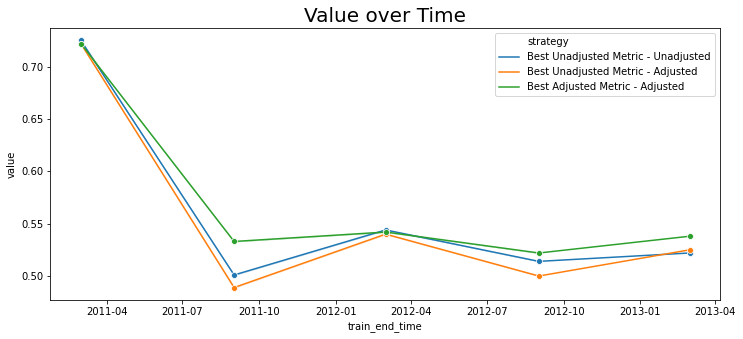

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value over Time", fontsize=20)

Text(0.5, 1.0, 'Max Recall Ratio')

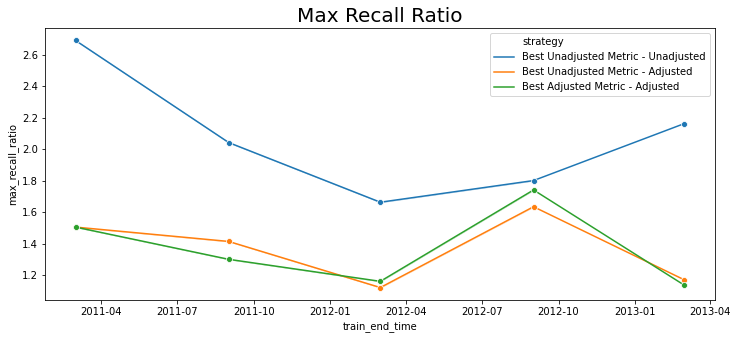

In [6]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='max_recall_ratio', hue='strategy', marker="o", ax=ax)
plt.title("Max Recall Ratio", fontsize=20)

In [7]:
print(ts_df.columns)

Index(['strategy', 'train_end_time', 'past_train_end_time', 'list_size',
       'metric', 'parameter', 'value', 'max_recall_ratio',
       'recall_lowmod_to_highest', 'recall_lowmod_high',
       'recall_high_highest'],
      dtype='object')


Text(0.5, 1.0, 'Recall Low to Highest')

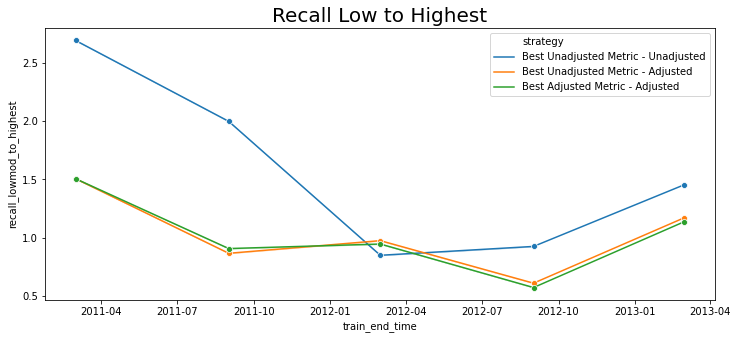

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_lowmod_to_highest', hue='strategy', marker="o", ax=ax)
plt.title("Recall Low to Highest", fontsize=20)

Text(0.5, 1.0, 'Recall Low to High')

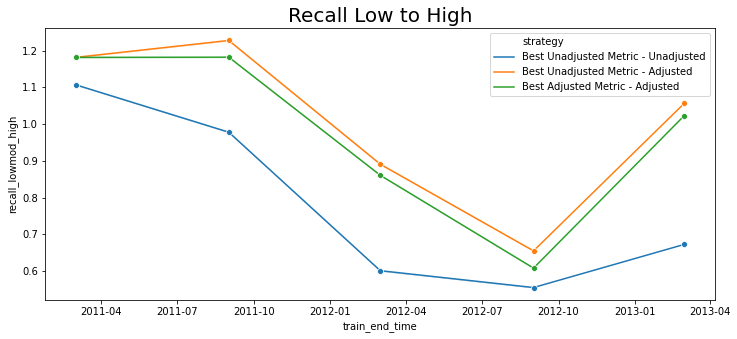

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_lowmod_high', hue='strategy', marker="o", ax=ax)
plt.title("Recall Low to High", fontsize=20)

Text(0.5, 1.0, 'Recall High to Highest')

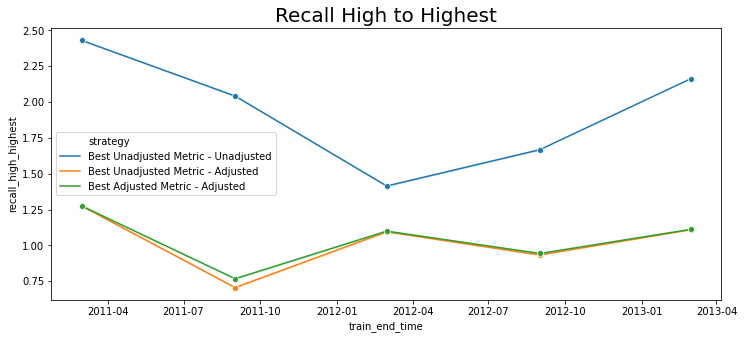

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='train_end_time', y='recall_high_highest', hue='strategy', marker="o", ax=ax)
plt.title("Recall High to Highest", fontsize=20)

In [16]:
#fig, ax = plt.subplots(figsize=(12,5))
#sns.lineplot(data=ts_df, x='train_end_time', y='recall_moderate_highest', hue='strategy', marker="o", ax=ax)
#plt.title("Recall Moderate to Highest", fontsize=20)

In [17]:
#fig, ax = plt.subplots(figsize=(12,5))
#sns.lineplot(data=ts_df, x='train_end_time', y='recall_moderate_high', hue='strategy', marker="o", ax=ax)
#plt.title("Recall: Moderate to High", fontsize=20)

In [11]:
ts_df.groupby(['strategy']).describe()

list_size                               \
                                        count    mean  std     min     25%   
strategy                                                                     
Best Adjusted Metric - Adjusted           9.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Adjusted         9.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Unadjusted       9.0  1000.0  0.0  1000.0  1000.0   

                                                            value            \
                                        50%     75%     max count      mean   
strategy                                                                      
Best Adjusted Metric - Adjusted      1000.0  1000.0  1000.0   9.0  0.575111   
Best Unadjusted Metric - Adjusted    1000.0  1000.0  1000.0   9.0  0.558556   
Best Unadjusted Metric - Unadjusted  1000.0  1000.0  1000.0   9.0  0.565556   

                                                                           \
                                          std    min    25%    50%    75%   
strategy                                                                    
Best Adjusted Metric - Adjusted      0.083599  0.522  0.533  0.538  0.542   
Best Unadjusted Metric - Adjusted    0.094721  0.489  0.500  0.525  0.540   
Best Unadjusted Metric - Unadjusted  0.091735  0.501  0.514  0.522  0.544   

                                           max_recall_ratio            \
                                       max            count      mean   
strategy                                                                
Best Adjusted Metric - Adjusted      0.722              9.0  1.395763   
Best Unadjusted Metric - Adjusted    0.722              9.0  1.392336   
Best Unadjusted Metric - Unadjusted  0.725              9.0  2.062128   

                                                                             \
                                          std       min       25%       50%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.239102  1.137933  1.162093  1.301748   
Best Unadjusted Metric - Adjusted    0.205899  1.122776  1.171775  1.415172   
Best Unadjusted Metric - Unadjusted  0.395727  1.664089  1.801437  2.042394   

                                                         \
                                          75%       max   
strategy                                                  
Best Adjusted Metric - Adjusted      1.506253  1.741873   
Best Unadjusted Metric - Adjusted    1.506253  1.635425   
Best Unadjusted Metric - Unadjusted  2.162791  2.690259   

                                    recall_lowmod_to_highest            \
                                                       count      mean   
strategy                                                                 
Best Adjusted Metric - Adjusted                          9.0  1.000903   
Best Unadjusted Metric - Adjusted                        9.0  1.010379   
Best Unadjusted Metric - Unadjusted                      9.0  1.598033   

                                                                             \
                                          std       min       25%       50%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.338562  0.574095  0.907974  0.946775   
Best Unadjusted Metric - Adjusted    0.331552  0.611462  0.867341  0.975763   
Best Unadjusted Metric - Unadjusted  0.770216  0.850352  0.926211  1.454384   

                                                        recall_lowmod_high  \
                                          75%       max              count   
strategy                                                                     
Best Adjusted Metric - Adjusted      1.137933  1.506253                9.0   
Best Unadjusted Metric - Adjusted    1.171775  1.506253                9.0   
Best Unadjusted Metric - Unadjusted  1.997136  2.6

## Sensitivity to overall list size

In [12]:
conn.dispose()
conn = connect()
reload(ra)

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


<module 'RecallAdjuster' from '/mnt/data/users/hemank/peeps-chili/code/RecallAdjuster.py'>

In [13]:
import time
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='hemank',
        schema='hemank_entity_demos',
        experiment_hashes='ff0fc6e2618a3bb8be12494855419067',
        date_pairs=date_pairs,
        list_sizes=[1000,2000,3000,5000],
        entity_demos='donors',
        demo_col='plevel'
)
print("Time Taken="+str(time.time() - start_time))

Time Taken=1046.971003293991


In [18]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM hemank_entity_demos.model_adjustment_results_plevel
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.base_recall_low_mod_to_high AS recall_lowmod_to_high,
       r.base_recall_high_to_highest AS recall_high_to_highest,
       r.base_frac_low_mod AS frac_lowmod,
       r.base_frac_high AS frac_high,
       r.base_frac_highest AS frac_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.adj_recall_low_mod_to_high AS recall_lowmod_to_high,
       r.adj_recall_high_to_highest AS recall_high_to_highest,
       r.adj_frac_low_mod AS frac_lowmod,
       r.adj_frac_high AS frac_high,
       r.adj_frac_highest AS frac_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_low_mod_to_highest AS recall_lowmod_to_highest,
       r.adj_recall_low_mod_to_high AS recall_lowmod_to_high,
       r.adj_recall_high_to_highest AS recall_high_to_highest,
       r.adj_frac_low_mod AS frac_lowmod,
       r.adj_frac_high AS frac_high,
       r.adj_frac_highest AS frac_highest
FROM hemank_entity_demos.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
"""
discarded = """
UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      future_train_end_time AS train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_w_to_b,
      recall_w_to_h,
      recall_b_to_h,
      frac_w,
      frac_b,
      frac_h
FROM kit_bias_class_test.composite_results_race_3way
WHERE future_train_end_time > past_train_end_time
;
"""

ts_df = pd.read_sql(sql, conn)

In [20]:
ts_df.groupby(['strategy','list_size']).describe()

value                      \
                                              count      mean       std   
strategy                            list_size                             
Best Adjusted Metric - Adjusted     1000        9.0  0.559444  0.094080   
                                    2000        9.0  0.511556  0.093372   
                                    3000        9.0  0.494926  0.084918   
                                    5000        9.0  0.470489  0.076779   
Best Unadjusted Metric - Adjusted   1000        9.0  0.559444  0.094080   
                                    2000        9.0  0.511556  0.093372   
                                    3000        9.0  0.494926  0.084918   
                                    5000        9.0  0.470489  0.076779   
Best Unadjusted Metric - Unadjusted 1000        9.0  0.566000  0.091419   
                                    2000        9.0  0.511667  0.097386   
                                    3000        9.0  0.493852  0.086046   
                                    5000        9.0  0.470578  0.078559   

                                                                           \
                                                    min       25%     50%   
strategy                            list_size                               
Best Adjusted Metric - Adjusted     1000       0.490000  0.503000  0.5250   
                                    2000       0.450500  0.456000  0.4715   
                                    3000       0.433667  0.438667  0.4720   
                                    5000       0.411200  0.429600  0.4438   
Best Unadjusted Metric - Adjusted   1000       0.490000  0.503000  0.5250   
                                    2000       0.450500  0.456000  0.4715   
                                    3000       0.433667  0.438667  0.4720   
                                    5000       0.411200  0.429600  0.4438   
Best Unadjusted Metric - Unadjusted 1000       0.502000  0.515000  0.5220   
                                    2000       0.442000  0.463500  0.4670   
                                    3000       0.435333  0.442000  0.4610   
                                    5000       0.409200  0.432000  0.4420   

                                                                   \
                                                    75%       max   
strategy                            list_size                       
Best Adjusted Metric - Adjusted     1000       0.540000  0.722000   
                                    2000       0.500000  0.674000   
                                    3000       0.483667  0.641000   
                                    5000       0.458800  0.603200   
Best Unadjusted Metric - Adjusted   1000       0.540000  0.722000   
                                    2000       0.500000  0.674000   
                                    3000       0.483667  0.641000   
                                    5000       0.458800  0.603200   
Best Unadjusted Metric - Unadjusted 1000       0.544000  0.725000   
                                    2000       0.498000  0.681000   
                                    3000       0.481333  0.643333   
                                    5000       0.455600  0.606600   

                                              max_recall_ratio            \
                                                         count      mean   
strategy                            list_size                              
Best Adjusted Metric - Adjusted     1000                   9.0  1.392548   
                                    2000                   9.0  1.409351   
                                    3000                   9.0  1.370043   
                                    5000                   9.0  1.314265   
Best Unadjusted Metric - Adjusted   1000                   9.0  1.392548   
                                    2000                   9.0  1.409351   
                                    3000    

Text(0.5, 1.0, 'List Size Value')

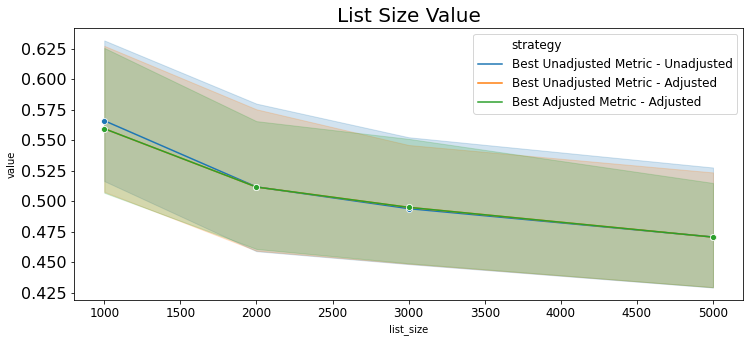

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax)
plt.title("Value", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Size Value", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_value.pdf')

Text(0.5, 1.0, 'List Sizes: Recall LowMod - Highest')

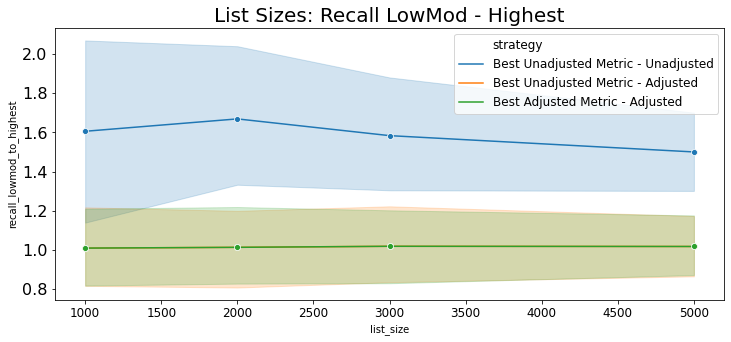

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_lowmod_to_highest', hue='strategy', marker="o", ax=ax)
plt.title("Recall LowMod to Highest", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Sizes: Recall LowMod - Highest", fontsize=20)
#plt.savefig('../FIGURES/list_sizes_recall_lm_highest.pdf')

Text(0.5, 1.0, 'List Sizes: Recall LowMod - High')

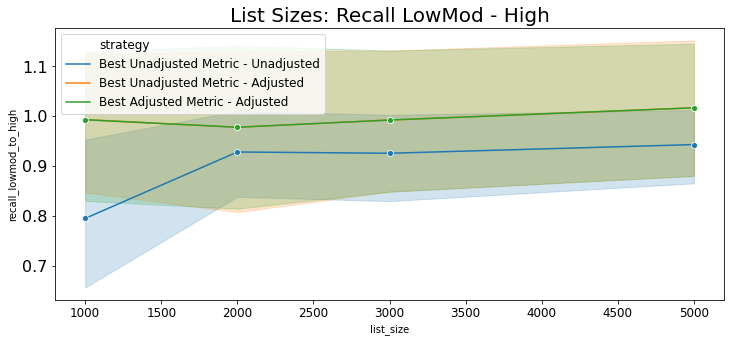

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_lowmod_to_high', hue='strategy', marker="o", ax=ax)
plt.title("Recall LowMod to High", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.title("List Sizes: Recall LowMod - High", fontsize=20)

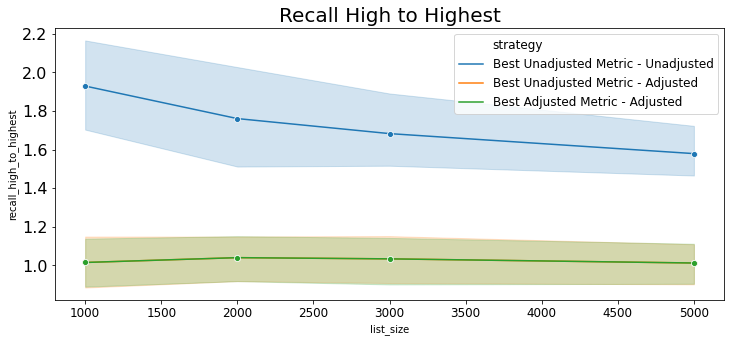

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='recall_high_to_highest', hue='strategy', marker="o", ax=ax)
plt.title("Recall High to Highest", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)

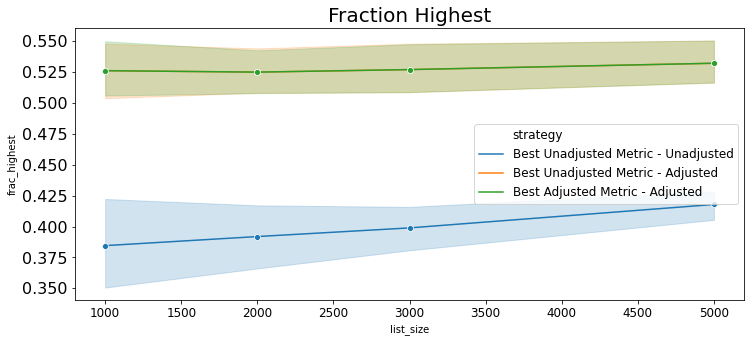

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_highest', hue='strategy', marker="o", ax=ax)
plt.title("Fraction Highest", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)

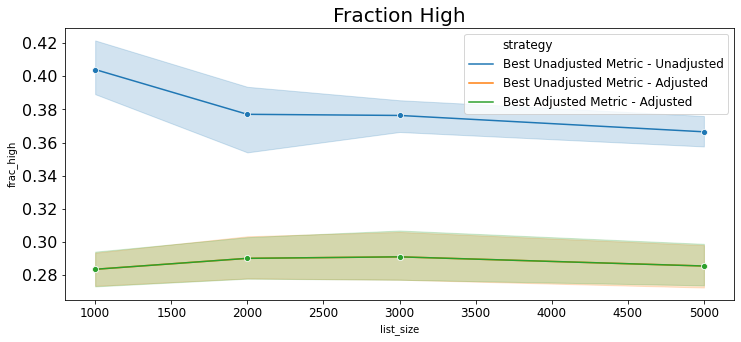

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_high', hue='strategy', marker="o", ax=ax)
plt.title("Fraction High", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)

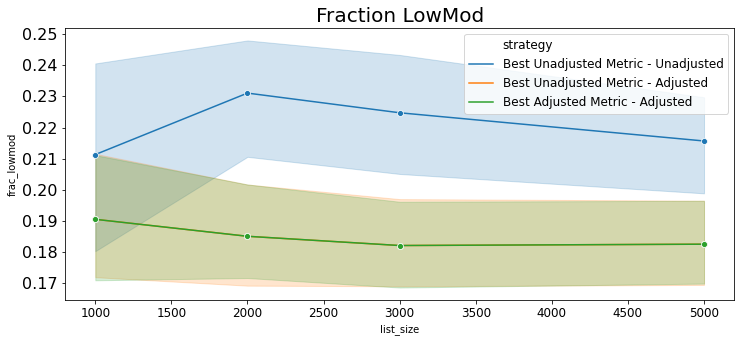

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df, x='list_size', y='frac_lowmod', hue='strategy', marker="o", ax=ax)
plt.title("Fraction LowMod", fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
#plt.savefig('../FIGURES/list_sizes_frac_lm.pdf')

### Plotting Model Transitions

In [28]:
query = "SELECT * from hemank_entity_demos.model_adjustment_results_plevel"
df = pd.read_sql(query, conn)
print(df.columns)

Index(['model_id', 'model_group_id', 'train_end_time', 'list_size',
       'past_train_end_time', 'metric', 'parameter', 'base_value',
       'base_max_recall_ratio', 'base_recall_highest_to_high',
       'base_recall_highest_to_low_mod', 'base_recall_high_to_highest',
       'base_recall_high_to_low_mod', 'base_recall_low_mod_to_highest',
       'base_recall_low_mod_to_high', 'base_frac_highest',
       'base_recall_highest', 'base_frac_high', 'base_recall_high',
       'base_frac_low_mod', 'base_recall_low_mod', 'adj_value',
       'adj_max_recall_ratio', 'adj_recall_highest_to_high',
       'adj_recall_highest_to_low_mod', 'adj_recall_high_to_highest',
       'adj_recall_high_to_low_mod', 'adj_recall_low_mod_to_highest',
       'adj_recall_low_mod_to_high', 'adj_frac_highest', 'adj_recall_highest',
       'adj_frac_high', 'adj_recall_high', 'adj_frac_low_mod',
       'adj_recall_low_mod', 'value_diff', 'recall_ratio_diff'],
      dtype='object')


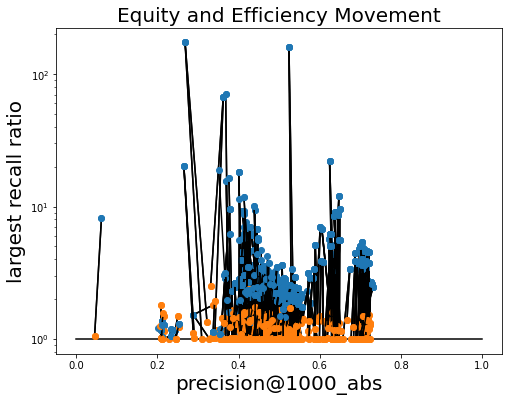

In [32]:
df_1000 = df[df['list_size']==1000]
arr = df_1000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,2))
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('largest recall ratio', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)
plt.gca().set_yscale('log')
plt.show()

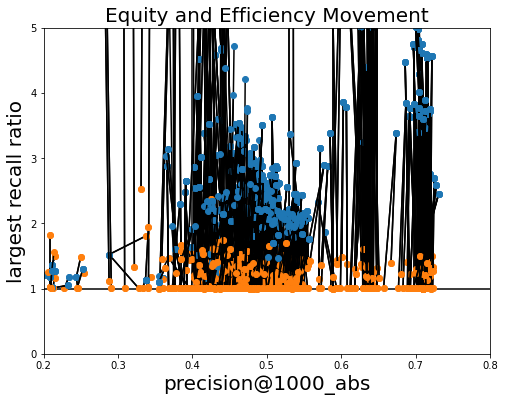

In [38]:
df_1000 = df[df['list_size']==1000]
arr = df_1000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.8))
ax.set_ylim((0,5))
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('largest recall ratio', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)
#plt.gca().set_yscale('log')
plt.show()

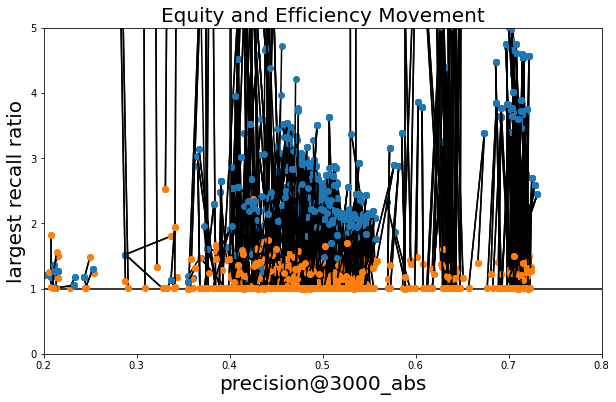

In [44]:
df_3000 = df[df['list_size']==3000]
arr = df_1000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(10,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.8))
ax.set_ylim((0,5))
ax.set_xlabel('precision@3000_abs', fontsize=20)
ax.set_ylabel('largest recall ratio', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)
#plt.gca().set_yscale('log')
plt.show()

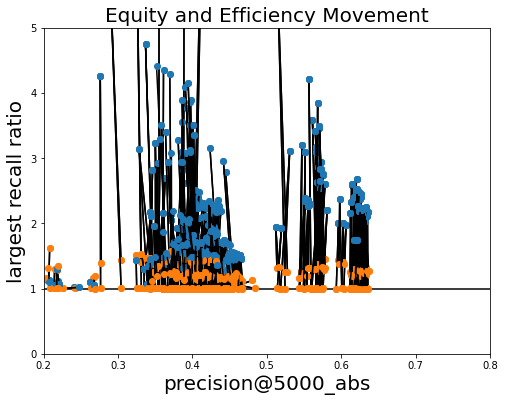

In [35]:
df_5000 = df[df['list_size']==5000]
arr = df_5000[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.8))
ax.set_ylim((0,5))
ax.set_xlabel('precision@5000_abs', fontsize=20)
ax.set_ylabel('largest recall ratio', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)
#plt.gca().set_yscale('log')
plt.show()

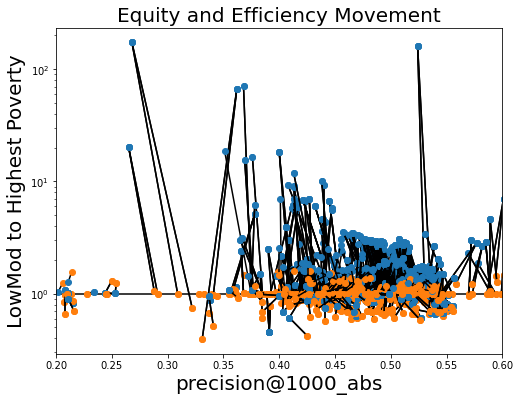

In [41]:
arr = df_1000[['base_value', 'base_recall_low_mod_to_highest', 'adj_value', 'adj_recall_low_mod_to_highest']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,3))
#ax.set_yscale('log')
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('LowMod to Highest Poverty', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

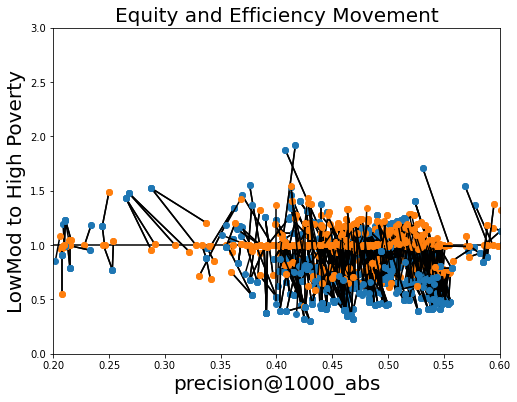

In [42]:
arr = df_1000[['base_value', 'base_recall_low_mod_to_high', 'adj_value', 'adj_recall_low_mod_to_high']].values
plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-')
    plt.plot(x0, y0, color='C0', marker='o')
    plt.plot(x1, y1, color='C1', marker='o')

ax = plt.gca()
ax.set_xlim((0.2, 0.6))
ax.set_ylim((0,3))
#ax.set_yscale('log')
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('LowMod to High Poverty', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

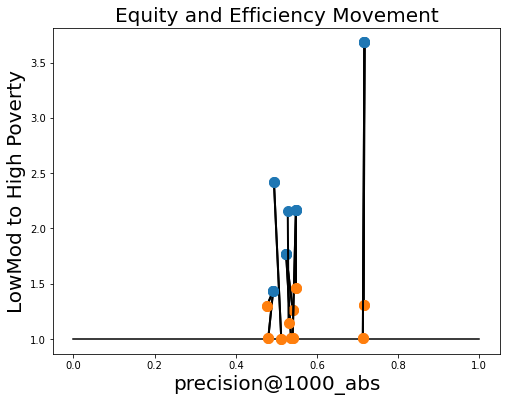

In [59]:
df_mg_audited = df[(df['list_size']==1000) & (df['model_group_id'] == 698)]

arr = df_mg_audited[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values

plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', lw=2.0)
    plt.plot(x0, y0, color='C0', marker='o', markersize=10)
    plt.plot(x1, y1, color='C1', marker='o', markersize=10)

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,3))
#ax.set_yscale('log')
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('LowMod to High Poverty', fontsize=20)
ax.set_title('Equity and Efficiency Movement', fontsize=20)

plt.show()

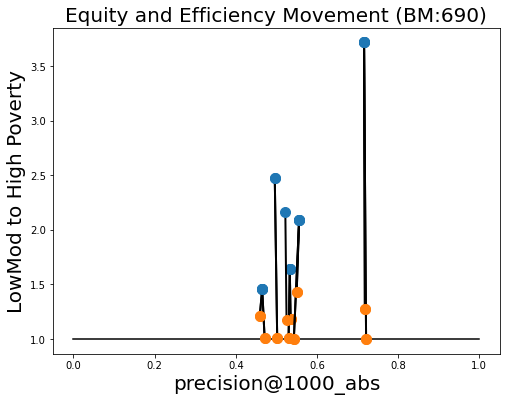

In [60]:
df_mg_audited = df[(df['list_size']==1000) & (df['model_group_id'] == 690)]

arr = df_mg_audited[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values

plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', lw=2.0)
    plt.plot(x0, y0, color='C0', marker='o', markersize=10
    plt.plot(x1, y1, color='C1', marker='o', markersize=10)

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,3))
#ax.set_yscale('log')
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('LowMod to High Poverty', fontsize=20)
ax.set_title('Equity and Efficiency Movement (BM:690)', fontsize=20)

plt.show()

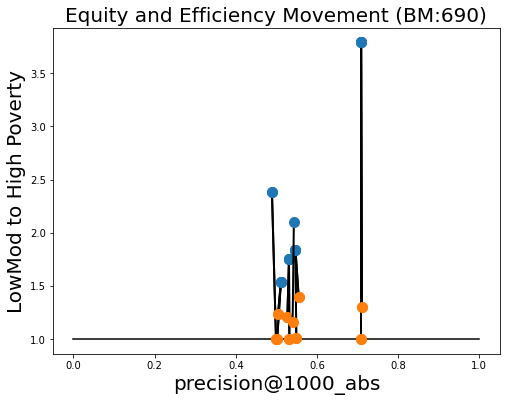

In [61]:
df_mg_audited = df[(df['list_size']==1000) & (df['model_group_id'] == 701)]

arr = df_mg_audited[['base_value', 'base_max_recall_ratio', 'adj_value', 'adj_max_recall_ratio']].values

plt.figure(figsize=(8,6))
plt.plot((0,1),(1,1),'k-')
for x0, y0, x1, y1 in arr:
    plt.plot((x0,x1), (y0,y1), 'k-', lw=2.0)
    plt.plot(x0, y0, color='C0', marker='o', markersize=10)
    plt.plot(x1, y1, color='C1', marker='o', markersize=10)

ax = plt.gca()
#ax.set_xlim((0.2, 0.6))
#ax.set_ylim((0,3))
#ax.set_yscale('log')
ax.set_xlabel('precision@1000_abs', fontsize=20)
ax.set_ylabel('LowMod to High Poverty', fontsize=20)
ax.set_title('Equity and Efficiency Movement (BM:690)', fontsize=20)

plt.show()